In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

small_data = [
    [-0.194, 0.114, -0.006, 0.301, -0.359, -0.088, -0.156, 0.342, -0.016, 0.143, 1],
    [-0.1, 0.002, 0.244, 0.127, -0.064, -0.086, 0.072, 0.043, -0.053, 0.02, -1],
]

#Data points with labels removed, for inner product
train_data = [small_data[0][:-1], small_data[1][:-1]]

In [2]:
# from qiskit.circuit.library import zz_feature_map
# fm = zz_feature_map(feature_dimension=np.shape(train_data)[1], entanglement='linear', reps=1)
 
from qiskit.circuit.library import z_feature_map
 
fm = z_feature_map(feature_dimension=np.shape(train_data)[1])
 
 
unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

circuit depth =  9


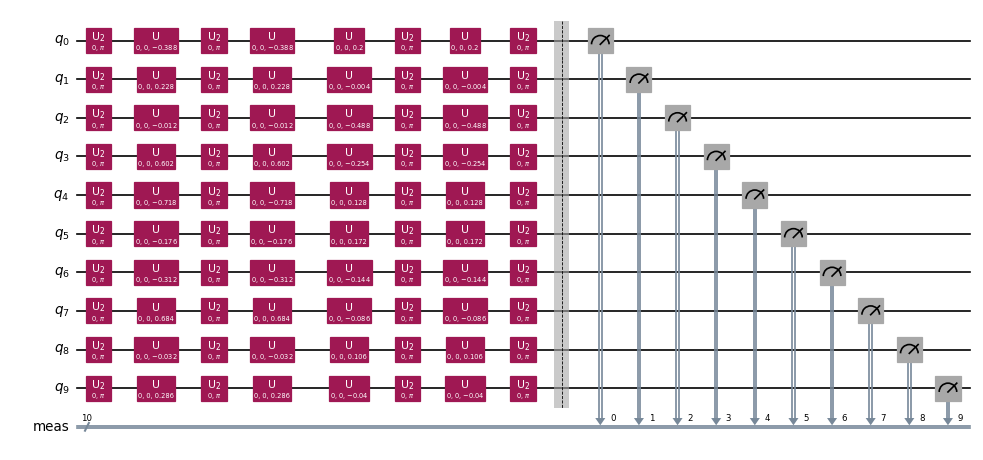

In [3]:
from qiskit.circuit.library import unitary_overlap
 
 
overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()
 
print("circuit depth = ", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, style="iqp")

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_cloud", 
    token="n-lq6JCt1FfX8pDQLxmE-BALSUyy7moO6UCD22vYxZlv"
)


In [7]:
# Import needed packages
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Get the least busy backend
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=fm.num_qubits
)
print(backend)

management.get:WARNING:2025-10-23 20:12:36,680: Loading default saved account
qiskit_runtime_service.__init__:WARNING:2025-10-23 20:12:45,528: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-10-23 20:12:46,450: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-10-23 20:12:49,218: Using instance: open-instance, plan: open


<IBMBackend('ibm_torino')>


In [8]:
# Run this for a simulator
# from qiskit.primitives import StatevectorSampler
 
# from qiskit_ibm_runtime import Options, Session, Sampler
 
# num_shots = 10000
 
# Evaluate the problem using state vector-based primitives from Qiskit
# sampler = StatevectorSampler()
# results = sampler.run([overlap_circ], shots=num_shots).result()
# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
# counts_bit = results[0].data.meas.get_counts()
# .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
# counts = results[0].data.meas.get_int_counts()

In [9]:
# Benchmarked on an Eagle processor, 7-11-24, took 4 sec.
 
# Import our runtime primitive
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
num_shots = 10000
 
# Use sampler and get the counts
 
sampler = Sampler(mode=backend)
results = sampler.run([overlap_ibm], shots=num_shots).result()
# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
counts_bit = results[0].data.meas.get_counts()
# .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
counts = results[0].data.meas.get_int_counts()

NameError: name 'overlap_ibm' is not defined

In [ ]:
counts.get(0, 0.0) / num_shots

In [ ]:
from qiskit.visualization import plot_distribution
 
plot_distribution(counts_bit)

In [ ]:
def visualize_counts(probs, num_qubits):
    """Visualize the outputs from the Qiskit Sampler primitive."""
    zero_prob = probs.get(0, 0.0)
    top_10 = dict(sorted(probs.items(), key=lambda item: item[1], reverse=True)[:10])
    top_10.update({0: zero_prob})
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    xvals, yvals = list(zip(*by_key.items()))
    xvals = [bin(xval)[2:].zfill(num_qubits) for xval in xvals]
    plt.bar(xvals, yvals)
    plt.xticks(rotation=75)
    plt.title("Results of sampling")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Counts")
    plt.show()
 
 
visualize_counts(counts, overlap_circ.num_qubits)

In [ ]:
!wget https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv
 
df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)
 
# Prepare training data
 
train_size = 90
X_train = df.values[0:train_size, :-1]
train_labels = df.values[0:train_size, -1]
 
# Prepare testing data
test_size = 30
X_test = df.values[train_size : train_size + test_size, :-1]
test_labels = df.values[train_size : train_size + test_size, -1]

In [ ]:
# Empty kernel matrix
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)
test_matrix = np.full((test_size, num_samples), np.nan)

In [ ]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
 
# Prepare feature map for computing overlap
num_features = np.shape(X_train)[1]
num_qubits = int(num_features / 2)
 
# To use a custom feature map use the lines below.
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]
 
fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

In [ ]:
# To use a simulator
from qiskit.primitives import StatevectorSampler
 
# Remember to insert your token in the QiskitRuntimeService constructor to use real quantum computers
# service = QiskitRuntimeService()
# backend = service.least_busy(
#    operational=True, simulator=False, min_num_qubits=fm.num_qubits
# )
 
num_shots = 10000
 
# Evaluate the problem using state vector-based primitives from Qiskit.
sampler = StatevectorSampler()
 
for x1 in range(0, train_size):
    for x2 in range(x1 + 1, train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        # These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        # Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0) / num_shots
    # Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1, x1] = 1
 
print("training done")
 
# Similar process to above, but for testing data.
for x1 in range(0, test_size):
    for x2 in range(0, train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        test_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
 
print("test matrix done")

In [ ]:
# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC
 
# Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

In [ ]:
# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)
 
# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_precomputed_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")

In [ ]:
# Two mock data points, including category labels, as in training
 
large_data = [
    [
        -0.028,
        -1.49,
        -1.698,
        0.107,
        -1.536,
        -1.538,
        -1.356,
        -1.514,
        -0.109,
        -1.8,
        -0.122,
        -1.651,
        -1.955,
        -0.123,
        -1.732,
        0.091,
        -0.048,
        -0.128,
        -0.026,
        0.082,
        -1.263,
        0.065,
        0.004,
        -0.055,
        -0.08,
        -0.173,
        -1.734,
        -0.39,
        -1.451,
        0.078,
        -1.578,
        -0.025,
        -0.184,
        -0.119,
        -1.336,
        0.055,
        -0.204,
        -1.578,
        0.132,
        -0.121,
        -1.599,
        -0.187,
        -1,
    ],
    [
        -1.414,
        -1.439,
        -1.606,
        0.246,
        -1.673,
        0.002,
        -1.317,
        -1.262,
        -0.178,
        -1.814,
        0.013,
        -1.619,
        -1.86,
        -0.25,
        -0.212,
        -0.214,
        -0.033,
        0.071,
        -0.11,
        -1.607,
        0.441,
        -0.143,
        -0.009,
        -1.655,
        -1.579,
        0.381,
        -1.86,
        -0.079,
        -0.088,
        -0.058,
        -1.481,
        -0.064,
        -0.065,
        -1.507,
        0.177,
        -0.131,
        -0.153,
        0.07,
        -1.627,
        0.593,
        -1.547,
        -0.16,
        -1,
    ],
]
train_data = [large_data[0][:-1], large_data[1][:-1]]

In [ ]:
from qiskit.circuit.library import zz_feature_map
 
fm = zz_feature_map(
    feature_dimension=np.shape(train_data)[1], entanglement="linear", reps=1
)
 
unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

In [ ]:
from qiskit.circuit.library import unitary_overlap
 
 
overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()
 
print("circuit depth = ", overlap_circ.decompose(reps=2).depth())
print(
    "two-qubit depth",
    overlap_circ.decompose().depth(lambda instr: len(instr.qubits) > 1),
)
# overlap_circ.draw("mpl", scale=0.6, style="iqp")

In [ ]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
 
# Prepare feature map for computing overlap
 
entangler_map = [
    [3, 4],
    [2, 5],
    [1, 4],
    [2, 3],
    [4, 6],
    [7, 9],
    [10, 11],
    [9, 12],
    [8, 11],
    [9, 10],
    [11, 13],
    [14, 16],
    [17, 18],
    [16, 19],
    [15, 18],
    [16, 17],
    [18, 20],
]

In [ ]:
# Use the entangler map above to build a feature map
 
num_features = np.shape(train_data)[1]
num_qubits = int(num_features / 2)
 
fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

In [ ]:
from qiskit.circuit.library import unitary_overlap
 
# Assign features of each data point to a unitary, an instance of the general feature map.
 
unitary1 = fm.assign_parameters(list(train_data[0]) + [np.pi / 2])
unitary2 = fm.assign_parameters(list(train_data[1]) + [np.pi / 2])
 
# Create the overlap circuit
 
overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()

In [ ]:
# Import needed packages
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Get the least busy backend
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=fm.num_qubits
)
print(backend)

In [ ]:
# Apply level 3 optimization to our overlap circuit
transpiled_qcs = []
transpiled_depths = []
transpiled_twoqubit_depths = []
for i in range(1, 20):
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    overlap_ibm = pm.run(overlap_circ)
    transpiled_qcs.append(overlap_ibm)
    transpiled_depths.append(overlap_ibm.decompose().depth())
    transpiled_twoqubit_depths.append(
        overlap_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)
    )
 
print("circuit depth = ", overlap_ibm.decompose().depth())

In [ ]:
print(transpiled_depths)
print(transpiled_twoqubit_depths)

In [ ]:
overlap_ibm = transpiled_qcs[1]

In [ ]:
# Run on ibm_osaka, 7-12-24, required 22 sec.
 
# Import our runtime primitive
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
# Open a Runtime session:
session = Session(backend=backend)
num_shots = 10000
# Use sampler and get the counts
 
sampler = Sampler(mode=session)
options = sampler.options
options.dynamical_decoupling.enable = True
options.twirling.enable_gates = True
counts = (
    sampler.run([overlap_ibm], shots=num_shots).result()[0].data.meas.get_int_counts()
)
 
# Close session after done
session.close()

In [ ]:
counts.get(0, 0.0) / num_shots